In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import regularizers
tf.config.run_functions_eagerly(True)

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
reviews_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/processed_reviews.csv')
reviews_df

,user_id,game_id,voted_up,game_name,genres
0,76561198038418440,364360,1,Total War: WARHAMMER,Action;Strategy
1,76561197969749884,221910,1,The Stanley Parable,Adventure;Indie
2,76561198067364909,280,1,Half-Life: Source,Action
3,76561198066909363,583470,1,The End Is Nigh,Action;Adventure;Indie
4,76561197971370772,346110,1,ARK: Survival Evolved,Action;Adventure;Indie;Massively Multiplayer;RPG
...,...,...,...,...,...
2375525,76561198148817144,535520,0,Nidhogg 2,Action;Casual;Indie
2375526,76561198034691818,535520,0,Nidhogg 2,Action;Casual;Indie
2375527,76561198060219692,535520,0,Nidhogg 2,Action;Casual;Indie
2375528,76561197972319712,535520,0,Nidhogg 2,Action;Casual;Indie


In [4]:
reviews_genre_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/processed_reviews+genre.csv')
reviews_genre_df

,user_id,game_id,voted_up,game_name,genre,genre_id
0,76561198038418440,364360,1,Total War: WARHAMMER,Action,0
1,76561198038418440,364360,1,Total War: WARHAMMER,Strategy,21
2,76561197969749884,221910,1,The Stanley Parable,Adventure,1
3,76561197969749884,221910,1,The Stanley Parable,Indie,11
4,76561198067364909,280,1,Half-Life: Source,Action,0
...,...,...,...,...,...,...
5941554,76561197972319712,535520,0,Nidhogg 2,Casual,4
5941555,76561197972319712,535520,0,Nidhogg 2,Indie,11
5941556,76561198011544203,535690,0,Crash Force®,Action,0
5941557,76561198011544203,535690,0,Crash Force®,Indie,11


In [5]:
def compile_model(num_of_user, num_of_item, vector_dimension, learning_rate=0.001): 
    
    user_input = keras.layers.Input((1,))
    user_embedding = keras.layers.Embedding(num_of_user, vector_dimension, input_length=1, name='user_embedding',
      embeddings_initializer='he_normal', embeddings_regularizer=regularizers.L2(1e-5))
    user = user_embedding(user_input)
    user = keras.layers.Reshape((vector_dimension, 1))(user)
    
    item_input = keras.layers.Input((1,))
    item_embedding = keras.layers.Embedding(num_of_item, vector_dimension, input_length=1, name='item_embedding',
      embeddings_initializer='he_normal', embeddings_regularizer=regularizers.L2(1e-6))
    item = item_embedding(item_input)
    item = keras.layers.Reshape((vector_dimension, 1))(item)
    
    dot_product = keras.layers.dot([user, item], axes=1)
    output = keras.layers.Activation('sigmoid')(dot_product)
    
    model = keras.models.Model(inputs=[user_input, item_input], outputs=output) 
    model.compile(
        loss='binary_crossentropy', 
        optimizer=keras.optimizers.Adam(learning_rate),
        metrics=['binary_accuracy'],
    )
    return model

In [6]:
def build_dataset(filepath, df, user_col, item_col, y_col):
    uid2idx = {v: k for k, v in dict(enumerate(sorted(df[user_col].unique()))).items()}
    iid2idx = {v: k for k, v in dict(enumerate(sorted(df[item_col].unique()))).items()}

    dataset = pd.DataFrame()
    dataset['uidx'] = df[user_col].map(uid2idx.get)
    dataset['iidx'] = df[item_col].map(iid2idx.get)
    dataset['y'] = df[y_col]
    
    data_x = np.array([
        dataset['uidx'].values, 
        dataset['iidx'].values, 
    ]).T
    data_y = np.array([
        dataset['y'].values, 
    ]).T
    train_x, valid_x, train_y, valid_y = train_test_split(
        data_x, data_y, test_size=8000,
    )
    valid_x, test_x, valid_y, test_y = train_test_split(
        valid_x, valid_y, test_size=2000,
    )
    return {
        'uid2idx': np.array(list(uid2idx.items())),
        'iid2idx': np.array(list(iid2idx.items())),
        'train_x': train_x, 
        'train_y': train_y, 
        'valid_x': valid_x, 
        'valid_y': valid_y, 
        'test_x': test_x, 
        'test_y': test_y,
    }


def load_or_build_dataset(filepath, df, user_col, item_col, y_col):
    if not os.path.exists(filepath):
        np.savez_compressed(
            filepath,
            **build_dataset(filepath, df, user_col, item_col, y_col),
        )
    with np.load(filepath) as filedata:
        return dict(filedata['uid2idx']), dict(filedata['iid2idx']), \
            filedata['train_x'], filedata['train_y'], \
            filedata['valid_x'], filedata['valid_y'], \
            filedata['test_x'], filedata['test_y']

Game2Vec 데이터 저장

In [7]:
uid2idx, iid2idx, train_x, train_y, valid_x, valid_y, test_x, test_y =\
    load_or_build_dataset('/content/drive/MyDrive/Colab Notebooks/dataset/game_dataset.npz', reviews_df, 'user_id', 'game_id', 'voted_up')

VectorDimension = 12



In [8]:
model_game_12 = compile_model(reviews_df['user_id'].nunique(), reviews_df['game_id'].nunique(), 12)
model_game_12.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 12)        4022196     ['input_1[0][0]']                
                                                                                                  
 item_embedding (Embedding)     (None, 1, 12)        96120       ['input_2[0][0]']                
                                                                                              

In [9]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/Colab Notebooks/dataset/game12_{val_loss:.4f}.hdf5',
    save_best_only=True,
)

In [10]:
history = model_game_12.fit(
    x=(train_x[:,0,None], train_x[:,1,None]),
    y=train_y, 
    batch_size=(2**10)*16,
    epochs=30, 
    verbose='auto',
    validation_data=((valid_x[:,0,None], valid_x[:,1,None]), valid_y), 
    shuffle=True,
    callbacks=[model_checkpoint_callback],
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


145/145 [==============================] - 18s 121ms/step - loss: 0.6932 - binary_accuracy: 0.5176 - val_loss: 0.6932 - val_binary_accuracy: 0.5683
Epoch 2/30
145/145 [==============================] - 17s 119ms/step - loss: 0.6932 - binary_accuracy: 0.6258 - val_loss: 0.6930 - val_binary_accuracy: 0.6662
Epoch 3/30
145/145 [==============================] - 23s 157ms/step - loss: 0.6920 - binary_accuracy: 0.6799 - val_loss: 0.6908 - val_binary_accuracy: 0.6910
Epoch 4/30
145/145 [==============================] - 32s 221ms/step - loss: 0.6869 - binary_accuracy: 0.7126 - val_loss: 0.6855 - val_binary_accuracy: 0.7040
Epoch 5/30
145/145 [==============================] - 30s 209ms/step - loss: 0.6784 - binary_accuracy: 0.7292 - val_loss: 0.6806 - val_binary_accuracy: 0.7038
Epoch 6/30
145/145 [==============================] - 18s 124ms/step - loss: 0.6692 - binary_accuracy: 0.7389 - val_loss: 0.6764 - val_binary_accuracy: 0.7082
Epoch 7/30
145/145 [==============================] - 18s

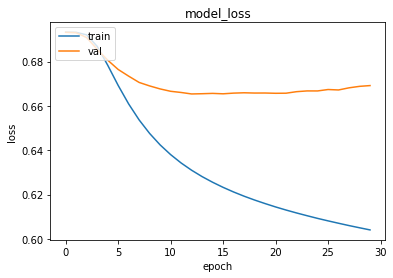

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'],loc = 'upper left')
plt.show()

In [13]:
model_game_12.evaluate(
    x=(test_x[:,0,None], test_x[:,1,None]),
    y=test_y
)

 3/63 [>.............................] - ETA: 1s - loss: 0.6735 - binary_accuracy: 0.7500

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


63/63 [==============================] - 2s 30ms/step - loss: 0.6722 - binary_accuracy: 0.7205


[0.6722406148910522, 0.7204999923706055]

VectorDimension = 8

In [14]:
model_game_8 = compile_model(reviews_df['user_id'].nunique(), reviews_df['game_id'].nunique(), 8)
model_game_8.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 8)         2681464     ['input_3[0][0]']                
                                                                                                  
 item_embedding (Embedding)     (None, 1, 8)         64080       ['input_4[0][0]']                
                                                                                            

In [15]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/Colab Notebooks/dataset/game8_{val_loss:.4f}.hdf5',
    save_best_only=True,
)

In [16]:
history = model_game_8.fit(
    x=(train_x[:,0,None], train_x[:,1,None]),
    y=train_y, 
    batch_size=(2**10)*16,
    epochs=30, 
    verbose='auto',
    validation_data=((valid_x[:,0,None], valid_x[:,1,None]), valid_y), 
    shuffle=True,
    callbacks=[model_checkpoint_callback],
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


145/145 [==============================] - 19s 127ms/step - loss: 0.6932 - binary_accuracy: 0.5139 - val_loss: 0.6932 - val_binary_accuracy: 0.5625
Epoch 2/30
145/145 [==============================] - 14s 96ms/step - loss: 0.6932 - binary_accuracy: 0.6232 - val_loss: 0.6931 - val_binary_accuracy: 0.6477
Epoch 3/30
145/145 [==============================] - 14s 97ms/step - loss: 0.6923 - binary_accuracy: 0.6816 - val_loss: 0.6913 - val_binary_accuracy: 0.6877
Epoch 4/30
145/145 [==============================] - 14s 98ms/step - loss: 0.6884 - binary_accuracy: 0.7142 - val_loss: 0.6873 - val_binary_accuracy: 0.7045
Epoch 5/30
145/145 [==============================] - 14s 98ms/step - loss: 0.6817 - binary_accuracy: 0.7293 - val_loss: 0.6832 - val_binary_accuracy: 0.7055
Epoch 6/30
145/145 [==============================] - 14s 98ms/step - loss: 0.6740 - binary_accuracy: 0.7385 - val_loss: 0.6791 - val_binary_accuracy: 0.7090
Epoch 7/30
145/145 [==============================] - 14s 96ms

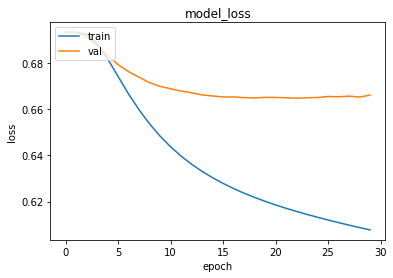

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'],loc = 'upper left')
plt.show()

In [18]:
model_game_8.evaluate(
    x=(test_x[:,0,None], test_x[:,1,None]),
    y=test_y
)

 3/63 [>.............................] - ETA: 1s - loss: 0.6602 - binary_accuracy: 0.7500

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


63/63 [==============================] - 2s 25ms/step - loss: 0.6681 - binary_accuracy: 0.7125


[0.6681463122367859, 0.7124999761581421]

Genre2Vec 데이터 저장

In [19]:
uid2idx, iid2idx, train_x, train_y, valid_x, valid_y, test_x, test_y =\
    load_or_build_dataset('/content/drive/MyDrive/Colab Notebooks/dataset/genre_dataset.npz', reviews_genre_df, 'user_id', 'genre_id', 'voted_up')

VectorDimension = 8

In [20]:
model_genre_8 = compile_model(reviews_genre_df['user_id'].nunique(), reviews_genre_df['genre_id'].nunique(), 8)
model_genre_8.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 8)         2681464     ['input_5[0][0]']                
                                                                                                  
 item_embedding (Embedding)     (None, 1, 8)         208         ['input_6[0][0]']                
                                                                                            

In [21]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/Colab Notebooks/dataset/genre8_{val_loss:.4f}.hdf5',
    save_best_only=True,
)

In [22]:
history = model_genre_8.fit(
    x=(train_x[:,0,None], train_x[:,1,None]),
    y=train_y, 
    batch_size=(2**10)*16,
    epochs=30, 
    verbose='auto',
    validation_data=((valid_x[:,0,None], valid_x[:,1,None]), valid_y), 
    shuffle=True,
    callbacks=[model_checkpoint_callback],
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


363/363 [==============================] - 32s 86ms/step - loss: 0.6871 - binary_accuracy: 0.6787 - val_loss: 0.6724 - val_binary_accuracy: 0.7428
Epoch 2/30
363/363 [==============================] - 31s 86ms/step - loss: 0.6555 - binary_accuracy: 0.7501 - val_loss: 0.6388 - val_binary_accuracy: 0.7492
Epoch 3/30
363/363 [==============================] - 31s 85ms/step - loss: 0.6249 - binary_accuracy: 0.7566 - val_loss: 0.6155 - val_binary_accuracy: 0.7543
Epoch 4/30
363/363 [==============================] - 31s 85ms/step - loss: 0.6032 - binary_accuracy: 0.7591 - val_loss: 0.5985 - val_binary_accuracy: 0.7558
Epoch 5/30
363/363 [==============================] - 31s 85ms/step - loss: 0.5875 - binary_accuracy: 0.7599 - val_loss: 0.5867 - val_binary_accuracy: 0.7518
Epoch 6/30
363/363 [==============================] - 31s 87ms/step - loss: 0.5754 - binary_accuracy: 0.7604 - val_loss: 0.5769 - val_binary_accuracy: 0.7537
Epoch 7/30
363/363 [==============================] - 31s 85ms/

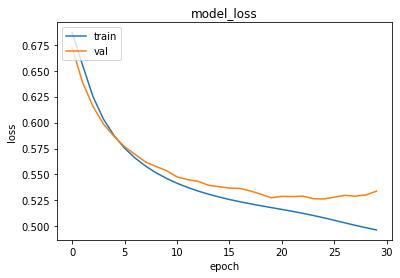

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'],loc = 'upper left')
plt.show()

In [24]:
model_genre_8.evaluate(
    x=(test_x[:,0,None], test_x[:,1,None]),
    y=test_y
)

 4/63 [>.............................] - ETA: 1s - loss: 0.5821 - binary_accuracy: 0.7266

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


63/63 [==============================] - 2s 26ms/step - loss: 0.5433 - binary_accuracy: 0.7605


[0.5432668924331665, 0.7605000138282776]

VectorDimension = 4


In [25]:
model_genre_4 = compile_model(reviews_genre_df['user_id'].nunique(), reviews_genre_df['genre_id'].nunique(), 4)
model_genre_4.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 4)         1340732     ['input_7[0][0]']                
                                                                                                  
 item_embedding (Embedding)     (None, 1, 4)         104         ['input_8[0][0]']                
                                                                                            

In [26]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/Colab Notebooks/dataset/genre4_{val_loss:.4f}.hdf5',
    save_best_only=True,
)

In [28]:
history = model_genre_4.fit(
    x=(train_x[:,0,None], train_x[:,1,None]),
    y=train_y, 
    batch_size=(2**10)*16,
    epochs=30, 
    verbose='auto',
    validation_data=((valid_x[:,0,None], valid_x[:,1,None]), valid_y), 
    shuffle=True,
    callbacks=[model_checkpoint_callback],
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


363/363 [==============================] - 37s 98ms/step - loss: 0.6901 - binary_accuracy: 0.6558 - val_loss: 0.6823 - val_binary_accuracy: 0.7397
Epoch 2/30
363/363 [==============================] - 25s 70ms/step - loss: 0.6702 - binary_accuracy: 0.7504 - val_loss: 0.6575 - val_binary_accuracy: 0.7495
Epoch 3/30
363/363 [==============================] - 25s 70ms/step - loss: 0.6452 - binary_accuracy: 0.7582 - val_loss: 0.6358 - val_binary_accuracy: 0.7552
Epoch 4/30
363/363 [==============================] - 25s 69ms/step - loss: 0.6243 - binary_accuracy: 0.7614 - val_loss: 0.6192 - val_binary_accuracy: 0.7562
Epoch 5/30
363/363 [==============================] - 25s 68ms/step - loss: 0.6078 - binary_accuracy: 0.7629 - val_loss: 0.6069 - val_binary_accuracy: 0.7547
Epoch 6/30
363/363 [==============================] - 25s 69ms/step - loss: 0.5945 - binary_accuracy: 0.7638 - val_loss: 0.5960 - val_binary_accuracy: 0.7550
Epoch 7/30
363/363 [==============================] - 25s 70ms/

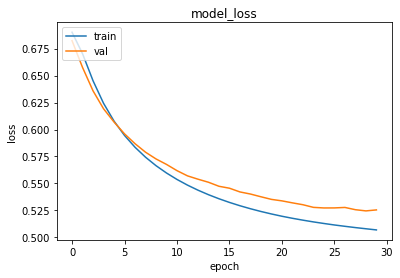

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'],loc = 'upper left')
plt.show()

In [30]:
model_genre_4.evaluate(
    x=(test_x[:,0,None], test_x[:,1,None]),
    y=test_y
)

 7/63 [==>...........................] - ETA: 1s - loss: 0.5256 - binary_accuracy: 0.7634

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


63/63 [==============================] - 1s 19ms/step - loss: 0.5341 - binary_accuracy: 0.7505


[0.5341302156448364, 0.7505000233650208]